In [1]:
from __future__ import annotations

from typing import Any

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display as ipy_display

import torch
import transformers
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_utils import EvalPrediction

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}", end="\n\n")
print(f"Torch version: {torch.__version__}")

Using device: cuda

Torch version: 1.13.1+cu116


In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def compute_metrics(eval_pred: EvalPrediction) -> dict[str, Any]:
    """Compute metrics for the model."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro'),
    }

In [5]:
RAW_DATA_FILE = "../../data/reddit_ell_eng_raw_pos.csv"

MARKERS = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
COLORS  = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
           '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']

PARMS = {
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 1e-7,
    'seed': 42,
    'max_length': 512,
}

all_results = pd.DataFrame()

In [6]:
df = pd.read_csv(RAW_DATA_FILE, encoding='utf-8')

df, labels = encode_labels(df, 'label')

X = df['text']
y = df['label']

gss_1 = GroupShuffleSplit(n_splits=10, test_size=0.2)
train_idx, test_idx = next(gss_1.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gss_2 = GroupShuffleSplit(n_splits=10, test_size=0.5)
val_idx, test_idx = next(gss_2.split(X_test, y_test, groups=df['user_id'].iloc[test_idx]))
X_val, X_test = X_test.iloc[val_idx], X_test.iloc[test_idx]
y_val, y_test = y_test.iloc[val_idx], y_test.iloc[test_idx]

print(f"{X_train.shape=}, {X_test.shape=}")
print(f"{y_train.shape=}, {y_test.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}", end="\n\n")

X_train.shape=(8204,), X_test.shape=(868,)
y_train.shape=(8204,), y_test.shape=(868,)
X_val.shape=(852,), y_val.shape=(852,)



In [7]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

train_dataset = RedditDataset(train_encodings, y_train.tolist())
test_dataset = RedditDataset(test_encodings, y_test.tolist())
val_dataset = RedditDataset(val_encodings, y_val.tolist())


# add dropout and early stopping
model.config.dropout = 0.75
early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience=3)

training_args = transformers.TrainingArguments(
    output_dir=f'../results/reports/{model_name}-lr{PARMS["learning_rate"]}-bs{PARMS["batch_size"]}-ep{PARMS["epochs"]}',
    num_train_epochs=PARMS['epochs'],
    learning_rate=PARMS['learning_rate'],
    per_device_train_batch_size=PARMS['batch_size'],
    per_device_eval_batch_size=PARMS['batch_size'],
    evaluation_strategy='epoch',
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs/distilbert',
    logging_steps=len(train_dataset) // PARMS['batch_size'],
    log_level='error',
    disable_tqdm=False,
    seed=PARMS['seed'],
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping],
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  2%|▏         | 256/12850 [03:21<2:54:55,  1.20it/s]

{'loss': 0.6906, 'learning_rate': 5.12e-08, 'epoch': 1.0}


                                                     
  2%|▏         | 257/12850 [03:29<2:23:42,  1.46it/s]

{'eval_loss': 0.7267385125160217, 'eval_accuracy': 0.22183098591549297, 'eval_precision': 0.6072274881516587, 'eval_recall': 0.5059612518628912, 'eval_f1': 0.18836739825424764, 'eval_runtime': 7.2228, 'eval_samples_per_second': 117.96, 'eval_steps_per_second': 3.738, 'epoch': 1.0}


  4%|▍         | 512/12850 [07:01<2:57:18,  1.16it/s] 

{'loss': 0.69, 'learning_rate': 9.990283400809716e-08, 'epoch': 1.99}


                                                     
  4%|▍         | 514/12850 [07:09<2:23:56,  1.43it/s]

{'eval_loss': 0.726252019405365, 'eval_accuracy': 0.22300469483568075, 'eval_precision': 0.6073546856465006, 'eval_recall': 0.5067064083457526, 'eval_f1': 0.18999310661764707, 'eval_runtime': 7.1281, 'eval_samples_per_second': 119.528, 'eval_steps_per_second': 3.788, 'epoch': 2.0}


  6%|▌         | 768/12850 [10:44<2:54:41,  1.15it/s] 

{'loss': 0.6862, 'learning_rate': 9.782995951417004e-08, 'epoch': 2.99}


                                                     
  6%|▌         | 771/12850 [10:53<2:17:54,  1.46it/s]

{'eval_loss': 0.7243094444274902, 'eval_accuracy': 0.2335680751173709, 'eval_precision': 0.6085131894484412, 'eval_recall': 0.5134128166915052, 'eval_f1': 0.20444994173035813, 'eval_runtime': 7.1391, 'eval_samples_per_second': 119.343, 'eval_steps_per_second': 3.782, 'epoch': 3.0}


  8%|▊         | 1024/12850 [14:30<2:47:23,  1.18it/s]

{'loss': 0.6829, 'learning_rate': 9.575708502024292e-08, 'epoch': 3.98}


                                                      
  8%|▊         | 1028/12850 [14:40<2:14:48,  1.46it/s]

{'eval_loss': 0.7211481332778931, 'eval_accuracy': 0.24882629107981222, 'eval_precision': 0.610231425091352, 'eval_recall': 0.5230998509687035, 'eval_f1': 0.22479826671443437, 'eval_runtime': 7.212, 'eval_samples_per_second': 118.137, 'eval_steps_per_second': 3.744, 'epoch': 4.0}


 10%|▉         | 1280/12850 [18:04<2:38:30,  1.22it/s] 

{'loss': 0.6775, 'learning_rate': 9.368421052631578e-08, 'epoch': 4.98}


                                                      
 10%|█         | 1285/12850 [18:14<2:06:49,  1.52it/s]

{'eval_loss': 0.7160196304321289, 'eval_accuracy': 0.27816901408450706, 'eval_precision': 0.604729436289412, 'eval_recall': 0.5397114885838733, 'eval_f1': 0.26280468502690724, 'eval_runtime': 6.6562, 'eval_samples_per_second': 128.001, 'eval_steps_per_second': 4.056, 'epoch': 5.0}


 12%|█▏        | 1536/12850 [21:36<2:34:53,  1.22it/s]

{'loss': 0.6697, 'learning_rate': 9.161133603238866e-08, 'epoch': 5.98}


                                                      
 12%|█▏        | 1542/12850 [21:47<2:04:53,  1.51it/s]

{'eval_loss': 0.7072389721870422, 'eval_accuracy': 0.3438967136150235, 'eval_precision': 0.6129825712143928, 'eval_recall': 0.5794229771677467, 'eval_f1': 0.34005562029655845, 'eval_runtime': 6.643, 'eval_samples_per_second': 128.255, 'eval_steps_per_second': 4.064, 'epoch': 6.0}


 14%|█▍        | 1792/12850 [25:05<2:30:12,  1.23it/s]

{'loss': 0.6597, 'learning_rate': 8.953846153846153e-08, 'epoch': 6.97}


                                                      
 14%|█▍        | 1799/12850 [25:17<2:00:25,  1.53it/s]

{'eval_loss': 0.6955375075340271, 'eval_accuracy': 0.4354460093896714, 'eval_precision': 0.6144834530644143, 'eval_recall': 0.6254415360927452, 'eval_f1': 0.43495951213257245, 'eval_runtime': 6.6057, 'eval_samples_per_second': 128.98, 'eval_steps_per_second': 4.087, 'epoch': 7.0}


 16%|█▌        | 2048/12850 [28:34<2:27:35,  1.22it/s]

{'loss': 0.6446, 'learning_rate': 8.74655870445344e-08, 'epoch': 7.97}


                                                      
 16%|█▌        | 2056/12850 [28:47<1:56:36,  1.54it/s]

{'eval_loss': 0.6799260973930359, 'eval_accuracy': 0.5269953051643192, 'eval_precision': 0.6227898550724638, 'eval_recall': 0.6674255461050136, 'eval_f1': 0.5175842965789618, 'eval_runtime': 6.6116, 'eval_samples_per_second': 128.864, 'eval_steps_per_second': 4.084, 'epoch': 8.0}


 18%|█▊        | 2304/12850 [32:04<2:23:46,  1.22it/s]

{'loss': 0.6271, 'learning_rate': 8.539271255060729e-08, 'epoch': 8.96}


                                                      
 18%|█▊        | 2313/12850 [32:17<1:54:31,  1.53it/s]

{'eval_loss': 0.6626030802726746, 'eval_accuracy': 0.6044600938967136, 'eval_precision': 0.6447628126051363, 'eval_recall': 0.7125713250611359, 'eval_f1': 0.58398859432933, 'eval_runtime': 6.5971, 'eval_samples_per_second': 129.147, 'eval_steps_per_second': 4.093, 'epoch': 9.0}


 20%|█▉        | 2560/12850 [35:32<2:19:39,  1.23it/s]

{'loss': 0.6062, 'learning_rate': 8.331983805668016e-08, 'epoch': 9.96}


                                                      
 20%|██        | 2570/12850 [35:47<1:50:55,  1.54it/s]

{'eval_loss': 0.6442412734031677, 'eval_accuracy': 0.6561032863849765, 'eval_precision': 0.6601851851851852, 'eval_recall': 0.739306386937942, 'eval_f1': 0.6267309426226444, 'eval_runtime': 6.6837, 'eval_samples_per_second': 127.474, 'eval_steps_per_second': 4.04, 'epoch': 10.0}


 22%|██▏       | 2816/12850 [39:02<2:17:05,  1.22it/s]

{'loss': 0.5891, 'learning_rate': 8.124696356275303e-08, 'epoch': 10.96}


                                                      
 22%|██▏       | 2827/12850 [39:17<1:48:02,  1.55it/s]

{'eval_loss': 0.6249837279319763, 'eval_accuracy': 0.7065727699530516, 'eval_precision': 0.6817704426106527, 'eval_recall': 0.7693308412446171, 'eval_f1': 0.6698943661971831, 'eval_runtime': 6.5915, 'eval_samples_per_second': 129.257, 'eval_steps_per_second': 4.096, 'epoch': 11.0}


 24%|██▍       | 3072/12850 [42:31<2:12:55,  1.23it/s]

{'loss': 0.5722, 'learning_rate': 7.917408906882591e-08, 'epoch': 11.95}


                                                      
 24%|██▍       | 3084/12850 [42:46<1:45:32,  1.54it/s]

{'eval_loss': 0.6095457673072815, 'eval_accuracy': 0.7417840375586855, 'eval_precision': 0.6993963782696178, 'eval_recall': 0.7896682612740941, 'eval_f1': 0.7005980372112043, 'eval_runtime': 6.6107, 'eval_samples_per_second': 128.881, 'eval_steps_per_second': 4.084, 'epoch': 12.0}


 26%|██▌       | 3328/12850 [46:01<2:10:44,  1.21it/s]

{'loss': 0.5594, 'learning_rate': 7.710121457489879e-08, 'epoch': 12.95}


                                                      
 26%|██▌       | 3341/12850 [46:17<1:44:47,  1.51it/s]

{'eval_loss': 0.5914016962051392, 'eval_accuracy': 0.7523474178403756, 'eval_precision': 0.6956250437378991, 'eval_recall': 0.7762019250561956, 'eval_f1': 0.7037762058004973, 'eval_runtime': 6.7405, 'eval_samples_per_second': 126.4, 'eval_steps_per_second': 4.006, 'epoch': 13.0}


 28%|██▊       | 3584/12850 [49:31<2:05:44,  1.23it/s]

{'loss': 0.5449, 'learning_rate': 7.502834008097166e-08, 'epoch': 13.95}


                                                      
 28%|██▊       | 3598/12850 [49:48<1:39:54,  1.54it/s]

{'eval_loss': 0.5778321623802185, 'eval_accuracy': 0.7723004694835681, 'eval_precision': 0.7073515749093415, 'eval_recall': 0.784835036352109, 'eval_f1': 0.7207727705811997, 'eval_runtime': 6.5978, 'eval_samples_per_second': 129.133, 'eval_steps_per_second': 4.092, 'epoch': 14.0}


 30%|██▉       | 3840/12850 [53:00<2:02:22,  1.23it/s]

{'loss': 0.536, 'learning_rate': 7.295546558704454e-08, 'epoch': 14.94}


                                                      
 30%|███       | 3855/12850 [53:18<1:37:21,  1.54it/s]

{'eval_loss': 0.5637660622596741, 'eval_accuracy': 0.7863849765258216, 'eval_precision': 0.7170553319734642, 'eval_recall': 0.7917596396900808, 'eval_f1': 0.7333397534668721, 'eval_runtime': 6.6063, 'eval_samples_per_second': 128.968, 'eval_steps_per_second': 4.087, 'epoch': 15.0}


 32%|███▏      | 4096/12850 [56:29<1:58:58,  1.23it/s]

{'loss': 0.524, 'learning_rate': 7.08825910931174e-08, 'epoch': 15.94}


                                                      
 32%|███▏      | 4112/12850 [56:48<1:34:05,  1.55it/s]

{'eval_loss': 0.5547077655792236, 'eval_accuracy': 0.7852112676056338, 'eval_precision': 0.7145759456264775, 'eval_recall': 0.7869799342944892, 'eval_f1': 0.730814982346797, 'eval_runtime': 6.5967, 'eval_samples_per_second': 129.156, 'eval_steps_per_second': 4.093, 'epoch': 16.0}


 34%|███▍      | 4352/12850 [59:58<1:54:48,  1.23it/s]

{'loss': 0.5188, 'learning_rate': 6.880971659919028e-08, 'epoch': 16.93}


                                                        
 34%|███▍      | 4369/12850 [1:00:17<1:31:32,  1.54it/s]

{'eval_loss': 0.5426416993141174, 'eval_accuracy': 0.7946009389671361, 'eval_precision': 0.7221403596403596, 'eval_recall': 0.7929411861573803, 'eval_f1': 0.7398010202033776, 'eval_runtime': 6.6231, 'eval_samples_per_second': 128.641, 'eval_steps_per_second': 4.077, 'epoch': 17.0}


 36%|███▌      | 4608/12850 [1:03:26<1:51:32,  1.23it/s]

{'loss': 0.508, 'learning_rate': 6.673684210526316e-08, 'epoch': 17.93}


                                                        
 36%|███▌      | 4626/12850 [1:03:46<1:28:47,  1.54it/s]

{'eval_loss': 0.5333166122436523, 'eval_accuracy': 0.7981220657276995, 'eval_precision': 0.7250792654214409, 'eval_recall': 0.7951766556059645, 'eval_f1': 0.7432062074621321, 'eval_runtime': 6.586, 'eval_samples_per_second': 129.365, 'eval_steps_per_second': 4.1, 'epoch': 18.0}


 38%|███▊      | 4864/12850 [1:06:55<1:48:14,  1.23it/s]

{'loss': 0.5021, 'learning_rate': 6.466396761133604e-08, 'epoch': 18.93}


                                                        
 38%|███▊      | 4883/12850 [1:07:16<1:26:13,  1.54it/s]

{'eval_loss': 0.5244208574295044, 'eval_accuracy': 0.8039906103286385, 'eval_precision': 0.7301090263691683, 'eval_recall': 0.7989024380202716, 'eval_f1': 0.7489266864653972, 'eval_runtime': 6.6124, 'eval_samples_per_second': 128.849, 'eval_steps_per_second': 4.083, 'epoch': 19.0}


 40%|███▉      | 5120/12850 [1:10:23<1:45:39,  1.22it/s]

{'loss': 0.4953, 'learning_rate': 6.25910931174089e-08, 'epoch': 19.92}


                                                        
 40%|████      | 5140/12850 [1:10:45<1:23:11,  1.54it/s]

{'eval_loss': 0.5160642266273499, 'eval_accuracy': 0.8063380281690141, 'eval_precision': 0.730907901152198, 'eval_recall': 0.7963582020732641, 'eval_f1': 0.749803783376848, 'eval_runtime': 6.5801, 'eval_samples_per_second': 129.481, 'eval_steps_per_second': 4.103, 'epoch': 20.0}


 42%|████▏     | 5376/12850 [1:13:52<1:41:07,  1.23it/s]

{'loss': 0.4914, 'learning_rate': 6.051821862348177e-08, 'epoch': 20.92}


                                                        
 42%|████▏     | 5397/12850 [1:14:14<1:20:35,  1.54it/s]

{'eval_loss': 0.5109158158302307, 'eval_accuracy': 0.8063380281690141, 'eval_precision': 0.7315349621754242, 'eval_recall': 0.7983754765296293, 'eval_f1': 0.7505213001002671, 'eval_runtime': 6.5875, 'eval_samples_per_second': 129.335, 'eval_steps_per_second': 4.099, 'epoch': 21.0}


 44%|████▍     | 5632/12850 [1:17:20<1:37:51,  1.23it/s]

{'loss': 0.4841, 'learning_rate': 5.844534412955465e-08, 'epoch': 21.91}


                                                        
 44%|████▍     | 5654/12850 [1:17:44<1:17:18,  1.55it/s]

{'eval_loss': 0.5039384961128235, 'eval_accuracy': 0.8098591549295775, 'eval_precision': 0.7341049791165022, 'eval_recall': 0.7985936715218483, 'eval_f1': 0.7532818532818534, 'eval_runtime': 6.5815, 'eval_samples_per_second': 129.454, 'eval_steps_per_second': 4.102, 'epoch': 22.0}


 46%|████▌     | 5888/12850 [1:20:48<1:33:59,  1.23it/s]

{'loss': 0.48, 'learning_rate': 5.637246963562753e-08, 'epoch': 22.91}


                                                        
 46%|████▌     | 5911/12850 [1:21:13<1:14:26,  1.55it/s]

{'eval_loss': 0.4979061484336853, 'eval_accuracy': 0.8133802816901409, 'eval_precision': 0.7373700623700623, 'eval_recall': 0.8008291409704325, 'eval_f1': 0.7567825229854412, 'eval_runtime': 6.5911, 'eval_samples_per_second': 129.265, 'eval_steps_per_second': 4.096, 'epoch': 23.0}


 48%|████▊     | 6144/12850 [1:24:17<1:30:27,  1.24it/s]

{'loss': 0.4765, 'learning_rate': 5.42995951417004e-08, 'epoch': 23.91}


                                                        
 48%|████▊     | 6168/12850 [1:24:42<1:11:40,  1.55it/s]

{'eval_loss': 0.494096577167511, 'eval_accuracy': 0.8133802816901409, 'eval_precision': 0.7373700623700623, 'eval_recall': 0.8008291409704325, 'eval_f1': 0.7567825229854412, 'eval_runtime': 6.5711, 'eval_samples_per_second': 129.659, 'eval_steps_per_second': 4.109, 'epoch': 24.0}


 50%|████▉     | 6400/12850 [1:27:44<1:26:47,  1.24it/s]

{'loss': 0.4747, 'learning_rate': 5.222672064777328e-08, 'epoch': 24.9}


                                                        
 50%|█████     | 6425/12850 [1:28:10<1:09:00,  1.55it/s]

{'eval_loss': 0.4877411723136902, 'eval_accuracy': 0.8145539906103286, 'eval_precision': 0.7384739593845833, 'eval_recall': 0.801574297453294, 'eval_f1': 0.7579545454545455, 'eval_runtime': 6.5665, 'eval_samples_per_second': 129.749, 'eval_steps_per_second': 4.112, 'epoch': 25.0}


 52%|█████▏    | 6656/12850 [1:31:12<1:23:42,  1.23it/s]

{'loss': 0.467, 'learning_rate': 5.015384615384615e-08, 'epoch': 25.9}


                                                        
 52%|█████▏    | 6682/12850 [1:31:39<1:06:20,  1.55it/s]

{'eval_loss': 0.48201748728752136, 'eval_accuracy': 0.818075117370892, 'eval_precision': 0.7418335780201342, 'eval_recall': 0.8038097669018781, 'eval_f1': 0.7614863485882614, 'eval_runtime': 6.5559, 'eval_samples_per_second': 129.96, 'eval_steps_per_second': 4.118, 'epoch': 26.0}


 54%|█████▍    | 6912/12850 [1:34:40<1:20:26,  1.23it/s]

{'loss': 0.4647, 'learning_rate': 4.808097165991903e-08, 'epoch': 26.89}


                                                        
 54%|█████▍    | 6939/12850 [1:35:08<1:03:31,  1.55it/s]

{'eval_loss': 0.4773491621017456, 'eval_accuracy': 0.818075117370892, 'eval_precision': 0.7418335780201342, 'eval_recall': 0.8038097669018781, 'eval_f1': 0.7614863485882614, 'eval_runtime': 6.5638, 'eval_samples_per_second': 129.804, 'eval_steps_per_second': 4.113, 'epoch': 27.0}


 56%|█████▌    | 7168/12850 [1:38:08<1:16:40,  1.24it/s]

{'loss': 0.465, 'learning_rate': 4.60080971659919e-08, 'epoch': 27.89}


                                                        
 56%|█████▌    | 7196/12850 [1:38:36<1:00:53,  1.55it/s]

{'eval_loss': 0.47349342703819275, 'eval_accuracy': 0.8215962441314554, 'eval_precision': 0.7452671448461534, 'eval_recall': 0.8060452363504623, 'eval_f1': 0.7650422729416888, 'eval_runtime': 6.5938, 'eval_samples_per_second': 129.212, 'eval_steps_per_second': 4.095, 'epoch': 28.0}


 58%|█████▊    | 7424/12850 [1:41:36<1:13:22,  1.23it/s]

{'loss': 0.4564, 'learning_rate': 4.393522267206477e-08, 'epoch': 28.89}


                                                        
 58%|█████▊    | 7453/12850 [1:42:05<57:46,  1.56it/s]

{'eval_loss': 0.4716755449771881, 'eval_accuracy': 0.8215962441314554, 'eval_precision': 0.7452671448461534, 'eval_recall': 0.8060452363504623, 'eval_f1': 0.7650422729416888, 'eval_runtime': 6.5853, 'eval_samples_per_second': 129.379, 'eval_steps_per_second': 4.1, 'epoch': 29.0}


 60%|█████▉    | 7680/12850 [1:45:04<1:09:44,  1.24it/s]

{'loss': 0.4585, 'learning_rate': 4.186234817813765e-08, 'epoch': 29.88}


                                                        
 60%|██████    | 7710/12850 [1:45:34<55:08,  1.55it/s]

{'eval_loss': 0.46789515018463135, 'eval_accuracy': 0.8215962441314554, 'eval_precision': 0.7452671448461534, 'eval_recall': 0.8060452363504623, 'eval_f1': 0.7650422729416888, 'eval_runtime': 6.5878, 'eval_samples_per_second': 129.33, 'eval_steps_per_second': 4.098, 'epoch': 30.0}


 62%|██████▏   | 7936/12850 [1:48:32<1:06:24,  1.23it/s]

{'loss': 0.4539, 'learning_rate': 3.9789473684210525e-08, 'epoch': 30.88}


                                                        
 62%|██████▏   | 7967/12850 [1:49:03<52:27,  1.55it/s]

{'eval_loss': 0.46529844403266907, 'eval_accuracy': 0.8227699530516432, 'eval_precision': 0.7464285714285714, 'eval_recall': 0.8067903928333238, 'eval_f1': 0.7662330582927375, 'eval_runtime': 6.5849, 'eval_samples_per_second': 129.388, 'eval_steps_per_second': 4.1, 'epoch': 31.0}


 64%|██████▍   | 8192/12850 [1:52:00<1:03:03,  1.23it/s]

{'loss': 0.4529, 'learning_rate': 3.77165991902834e-08, 'epoch': 31.88}


                                                        
 64%|██████▍   | 8224/12850 [1:52:32<50:28,  1.53it/s]

{'eval_loss': 0.463752418756485, 'eval_accuracy': 0.8227699530516432, 'eval_precision': 0.7464285714285714, 'eval_recall': 0.8067903928333238, 'eval_f1': 0.7662330582927375, 'eval_runtime': 6.6979, 'eval_samples_per_second': 127.205, 'eval_steps_per_second': 4.031, 'epoch': 32.0}


 66%|██████▌   | 8448/12850 [1:55:29<59:42,  1.23it/s]  

{'loss': 0.4518, 'learning_rate': 3.564372469635628e-08, 'epoch': 32.87}


                                                      
 66%|██████▌   | 8481/12850 [1:56:01<47:24,  1.54it/s]

{'eval_loss': 0.46213212609291077, 'eval_accuracy': 0.8227699530516432, 'eval_precision': 0.7464285714285714, 'eval_recall': 0.8067903928333238, 'eval_f1': 0.7662330582927375, 'eval_runtime': 6.5771, 'eval_samples_per_second': 129.54, 'eval_steps_per_second': 4.105, 'epoch': 33.0}


 68%|██████▊   | 8704/12850 [1:58:58<56:22,  1.23it/s]  

{'loss': 0.4472, 'learning_rate': 3.3570850202429143e-08, 'epoch': 33.87}


                                                      
 68%|██████▊   | 8738/12850 [1:59:31<44:11,  1.55it/s]

{'eval_loss': 0.45876386761665344, 'eval_accuracy': 0.823943661971831, 'eval_precision': 0.7475986238075982, 'eval_recall': 0.8075355493161851, 'eval_f1': 0.7674266247379454, 'eval_runtime': 6.5744, 'eval_samples_per_second': 129.594, 'eval_steps_per_second': 4.107, 'epoch': 34.0}


 70%|██████▉   | 8960/12850 [2:02:27<52:40,  1.23it/s]  

{'loss': 0.4472, 'learning_rate': 3.149797570850202e-08, 'epoch': 34.86}


                                                      
 70%|███████   | 8995/12850 [2:03:01<41:21,  1.55it/s]

{'eval_loss': 0.45806872844696045, 'eval_accuracy': 0.823943661971831, 'eval_precision': 0.7475986238075982, 'eval_recall': 0.8075355493161851, 'eval_f1': 0.7674266247379454, 'eval_runtime': 6.5854, 'eval_samples_per_second': 129.378, 'eval_steps_per_second': 4.1, 'epoch': 35.0}


 72%|███████▏  | 9216/12850 [2:05:56<49:05,  1.23it/s]  

{'loss': 0.4445, 'learning_rate': 2.94251012145749e-08, 'epoch': 35.86}


                                                      
 72%|███████▏  | 9252/12850 [2:06:30<39:03,  1.54it/s]

{'eval_loss': 0.45530965924263, 'eval_accuracy': 0.823943661971831, 'eval_precision': 0.7475986238075982, 'eval_recall': 0.8075355493161851, 'eval_f1': 0.7674266247379454, 'eval_runtime': 6.5707, 'eval_samples_per_second': 129.667, 'eval_steps_per_second': 4.109, 'epoch': 36.0}


 74%|███████▎  | 9472/12850 [2:09:25<46:07,  1.22it/s]  

{'loss': 0.442, 'learning_rate': 2.7352226720647768e-08, 'epoch': 36.86}


                                                      
 74%|███████▍  | 9509/12850 [2:10:00<35:58,  1.55it/s]

{'eval_loss': 0.45438653230667114, 'eval_accuracy': 0.823943661971831, 'eval_precision': 0.7475986238075982, 'eval_recall': 0.8075355493161851, 'eval_f1': 0.7674266247379454, 'eval_runtime': 6.5754, 'eval_samples_per_second': 129.573, 'eval_steps_per_second': 4.106, 'epoch': 37.0}


 74%|███████▍  | 9509/12850 [2:10:01<45:41,  1.22it/s]

{'train_runtime': 7804.9408, 'train_samples_per_second': 52.556, 'train_steps_per_second': 1.646, 'train_loss': 0.5359583866810596, 'epoch': 37.0}


TrainOutput(global_step=9509, training_loss=0.5359583866810596, metrics={'train_runtime': 7804.9408, 'train_samples_per_second': 52.556, 'train_steps_per_second': 1.646, 'train_loss': 0.5359583866810596, 'epoch': 37.0})

In [8]:
trainer.evaluate()
trainer.state.save_to_json(f'../results/reports/{model_name}/trainer_state.json')

100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]

y_pred_metrics:


,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.449291,0.812212,0.80703,0.81367,0.808974,7.7476,112.034,3.614


Log history:


,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6906,5.120000e-08,1.00,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.00,257,0.726739,0.221831,0.607227,0.505961,0.188367,7.2228,117.960,3.738,NaN,NaN,NaN,NaN,NaN
2,0.6900,9.990283e-08,1.99,512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.00,514,0.726252,0.223005,0.607355,0.506706,0.189993,7.1281,119.528,3.788,NaN,NaN,NaN,NaN,NaN
4,0.6862,9.782996e-08,2.99,768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,NaN,NaN,36.00,9252,0.455310,0.823944,0.747599,0.807536,0.767427,6.5707,129.667,4.109,NaN,NaN,NaN,NaN,NaN
72,0.4420,2.735223e-08,36.86,9472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,37.00,9509,0.454387,0.823944,0.747599,0.807536,0.767427,6.5754,129.573,4.106,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,37.00,9509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7804.9408,52.556,1.646,4.021021e+16,0.535958


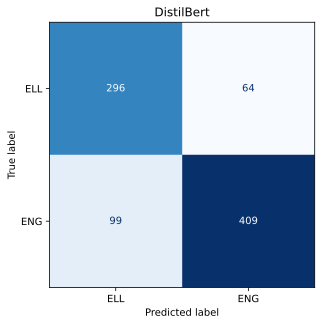

              precision    recall  f1-score   support

         ELL       0.75      0.82      0.78       360
         ENG       0.86      0.81      0.83       508

    accuracy                           0.81       868
   macro avg       0.81      0.81      0.81       868
weighted avg       0.82      0.81      0.81       868



,precision,recall,f1-score,support,maxlen
ELL,0.749367,0.822222,0.784106,360.000000,none
ENG,0.864693,0.805118,0.833843,508.000000,none
accuracy,0.812212,0.812212,0.812212,0.812212,none
macro avg,0.807030,0.813670,0.808974,868.000000,none
weighted avg,0.816862,0.812212,0.813215,868.000000,none


In [9]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics
print("y_pred_metrics:")
ipy_display(pd.DataFrame(y_pred_metrics, index=[0]))

logs = pd.DataFrame(trainer.state.log_history)
print("Log history:")
ipy_display(logs)

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

cm = confusion_matrix(y_true, y_preds)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels).plot(colorbar=False, cmap='Blues')
plt.title(f"{model.__class__.__name__.removesuffix('ForSequenceClassification')}")
plt.show();

report = classification_report(y_true, y_preds, target_names=labels, output_dict=True)
print(classification_report(y_true, y_preds, target_names=labels))

results = pd.DataFrame(report).transpose()
results['maxlen'] = 'none'
ipy_display(results)

all_results = pd.concat([all_results, results])

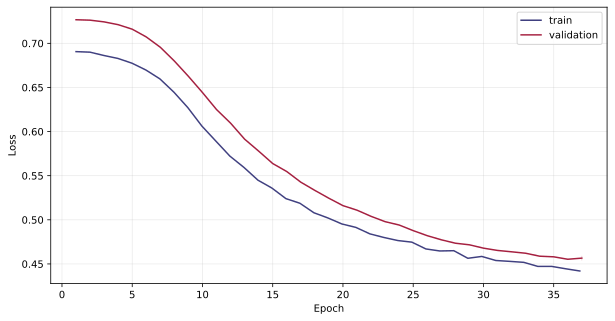

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=logs, x='epoch', y='loss', color=COLORS[0], label='train', zorder=2)
sns.lineplot(data=logs, x='epoch', y='eval_loss', color=COLORS[1], label='validation', zorder=2)

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(alpha=0.25, zorder=0)
plt.legend()
plt.show();

In [11]:
# Error analysis

df = pd.DataFrame({'text': X_test.tolist(), 'true': y_true, 'pred': y_preds})
df['correct'] = df['true'] == df['pred']
df['correct'] = df['correct'].map({True: 'correct', False: 'incorrect'})
df['true'] = df['true'].map({0: 'ELL', 1: 'ENG'})
df['pred'] = df['pred'].map({0: 'ELL', 1: 'ENG'})
df

,text,true,pred,correct
0,Based on this they would also go through all y...,ELL,ELL,correct
1,The tax authorities are confiscating bank acco...,ELL,ELL,correct
2,They need the religious organization 's suppor...,ELL,ELL,correct
3,The governments of Spain and Portugal for obvi...,ELL,ELL,correct
4,"Well , there are n't many Europeans on reddit ...",ELL,ENG,incorrect
...,...,...,...,...
863,"To the contrary , the region had always been s...",ENG,ENG,correct
864,"Sure but realistically , i can only work there...",ENG,ENG,correct
865,> tariffs ca n't go sky high and ca n't be tar...,ENG,ENG,correct
866,It got a bit more political and philosophical ...,ENG,ENG,correct


In [12]:
wrong_preds = df[df['correct'] == 'incorrect'] # only show incorrect predictions
wrong_preds

,text,true,pred,correct
4,"Well , there are n't many Europeans on reddit ...",ELL,ENG,incorrect
7,"But on the other , if someone asked me in 0000...",ELL,ENG,incorrect
16,There may be direct involvement of those leade...,ELL,ENG,incorrect
25,** The Court : ** - Lord Justice Richard Aiken...,ELL,ENG,incorrect
29,Its history has been a series of good intentio...,ELL,ENG,incorrect
...,...,...,...,...
831,'' ... frequently the idea of being a `` bridg...,ENG,ELL,incorrect
840,"The few he did find , like Italy under Renzi '...",ENG,ELL,incorrect
855,Maybe this is just due to cultural perspective...,ENG,ELL,incorrect
857,"[europe] Hazard ( + other Hazard ) , Fellaini ...",ENG,ELL,incorrect
